In [1]:
!pip install pytorch-model-summary

You should consider upgrading via the '/home/janithpet/dev/LOGML2021-Learning-Latent-Geometries/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision #helps with image transforms and normalisation
from time import time
from torchvision import transforms

import numpy as np

# plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA, KernelPCA

# loading dataset
from sklearn.datasets import fetch_lfw_people
from pytorch_model_summary import summary

# Utility

In [3]:
# plot the first 30 images in a dataset. 
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [6]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Preprocessing

In [8]:
# Download Data

lfw_people = fetch_lfw_people("./lfw/", resize=1)

/home/janithpet/dev/LOGML2021-Learning-Latent-Geometries/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass data_home=./lfw/ as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [42]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((240, 240)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [43]:
# Datalaoder Object

data = dataset_loader("./lfw/lfw_home/lfw_funneled")

In [44]:
# A Data batch

X = next(iter(data))[0]

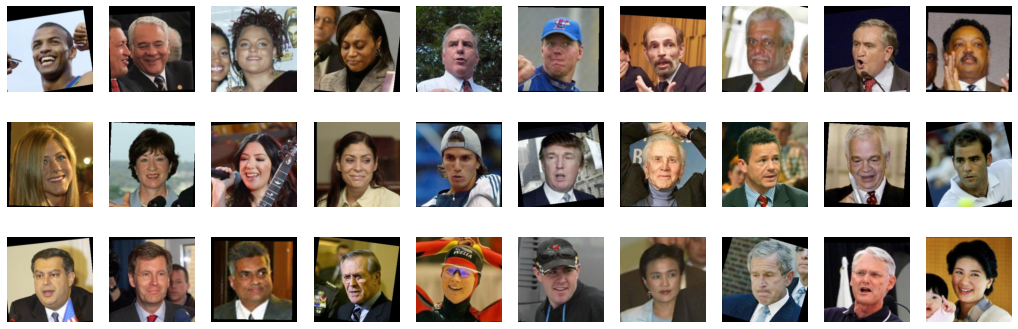

torch.Size([3, 240, 240])


In [45]:
plot_image_samples(X)

#  Single Image Shape
print(X[0].shape)

In [46]:
# Modelling Parameters

# IMAGE_SHAPE = (3, 125, 96) #old shape
IMAGE_SHAPE = X[0].shape #(3x250x250)
LATENT_DIMS = 32

print(f"{IMAGE_SHAPE = }, {LATENT_DIMS = }")

IMAGE_SHAPE = torch.Size([3, 240, 240]), LATENT_DIMS = 32


# Modelling

In [49]:
# Encoder Model

class Encoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, input_shape=IMAGE_SHAPE, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2) 
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2) 
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2) 
        self.l4 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=(1,1)) 
        self.mu = nn.Linear(in_features=2700, out_features=latent_dims) 
        self.log_var = nn.Linear(in_features=2700, out_features=latent_dims) # Modelling with zero covariance b/n all latent dims.

#         with torch.no_grad():
#             self.l1.weight = nn.Parameter(torch.normal(0, 0.1, self.l1.weight.shape))
#             self.l2.weight = nn.Parameter(torch.normal(0, 0.1, self.l2.weight.shape))
#             self.l3.weight = nn.Parameter(torch.normal(0, 0.1, self.l3.weight.shape))
#             self.l4.weight = nn.Parameter(torch.normal(0, 0.1, self.l4.weight.shape))
#             self.mu.weight = nn.Parameter(torch.normal(0, 0.1, self.mu.weight.shape))
#             self.log_var.weight = nn.Parameter(torch.normal(0, 0.1, self.log_var.weight.shape))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x)) # [None, 32, 62, 47]
        x = f(self.l2(x)) # [None, 64, 30, 23]
        x = f(self.l3(x)) # [None, 128, 14, 11]
        x = f(self.l4(x)) # [None, 3, 14, 11]
        x = torch.flatten(x, start_dim=1)   # [None, 3*14*11=462]

        # Data Distribution Parameters
        mu = self.mu(x)       # [None, latent_dims]
        log_var = self.log_var(x) # [None, latent_dims]

        return [mu, log_var]

In [50]:
# Encoder Summary

print(summary(Encoder(), torch.zeros((1, *IMAGE_SHAPE)), show_input=True))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2523 and 2700x32)

In [19]:
# Decoder Model

class Decoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, output_shape=IMAGE_SHAPE, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape = output_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Linear(in_features=latent_dims, out_features=4*latent_dims)
        self.l2 = nn.Linear(in_features=4*latent_dims, out_features=8*latent_dims)
        self.l3 = nn.Linear(in_features=8*latent_dims, out_features=21*latent_dims)
        self.l4 = nn.ConvTranspose2d(in_channels=2, out_channels=output_shape[0], kernel_size=(3,3), stride=3)
        self.l5 = nn.ConvTranspose2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,3), stride=2)
        self.l6 = nn.Conv2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,2))

        with torch.no_grad():
            self.l1.weight = nn.Parameter(torch.normal(0, 0.1, self.l1.weight.shape))
            self.l2.weight = nn.Parameter(torch.normal(0, 0.1, self.l2.weight.shape))
            self.l3.weight = nn.Parameter(torch.normal(0, 0.1, self.l3.weight.shape))
            self.l4.weight = nn.Parameter(torch.normal(0, 0.1, self.l4.weight.shape))
            self.l5.weight = nn.Parameter(torch.normal(0, 0.1, self.l5.weight.shape))
            self.l6.weight = nn.Parameter(torch.normal(0, 0.1, self.l6.weight.shape))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x))     # [None, latent_dim*4]
        x = f(self.l2(x))     # [None, latent_dim*8]
        x = f(self.l3(x))     # [None, latent_dim*16]
        x = torch.reshape(x, (-1, 2, 5+self.latent_dims//2, self.latent_dims//2)) # [None, 2, 21, 16]
        x = f(self.l4(x))     # [None, 3, 63, 48]
        x = f(self.l5(x))     # [None, 3, 127, 97]
        x = torch.sigmoid(self.l6(x))     # [None, 3, 125, 96]
        return x

In [20]:
# Decoder Summary

print(summary(Decoder(), torch.zeros((1, LATENT_DIMS)), show_input=True))

-------------------------------------------------------------------------
        Layer (type)         Input Shape         Param #     Tr. Param #
            Linear-1             [1, 32]           4,224           4,224
            Linear-2            [1, 128]          33,024          33,024
            Linear-3            [1, 256]         172,704         172,704
   ConvTranspose2d-4      [1, 2, 21, 16]              57              57
   ConvTranspose2d-5      [1, 3, 63, 48]              84              84
            Conv2d-6     [1, 3, 127, 97]              57              57
Total params: 210,150
Trainable params: 210,150
Non-trainable params: 0
-------------------------------------------------------------------------


KL divergence between two Gaussian is defined as

$$KL(p||q) = {1 \over 2}\Bigg(\log\Bigg( \frac{|\Sigma_2|}{|\Sigma_1|}\Bigg)  -n + Trace\Big(\Sigma_2^{-1}\Sigma_1 \Big) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)\Bigg)$$

where $P \sim N(\mu_1, \Sigma_1)$ and $Q \sim N(\mu_2, \Sigma_2)$.

In our case $Q = N(\vec0, \mathbb{I})$. It reduces KL to

$$KL(p||q) = {1 \over 2}\Bigg(-\log\big( |\Sigma_1|\big)  -n + Trace\Big(\Sigma_1 \Big) + \mu_1^2\Bigg)$$

In [21]:
MSE = lambda x, y, reduction: torch.sum(torch.square(x-y)) if reduction=="sum" else torch.mean(torch.square(x-y))

In [22]:
# Variational AutoEncoder

class VAE(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, image_shape=IMAGE_SHAPE, beta=10.0, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.encoder = Encoder(latent_dims, image_shape)
        self.decoder = Decoder(latent_dims, image_shape)
        self.beta = beta

        self.kl_loss = None
        self.reconstr_loss = None

    def forward(self, x):
        # Get Data Distribution's Parameters
        mu, log_var = self.encoder(x)
        
        # Reparameterization Trick
        z = mu + torch.exp(0.5*log_var)*torch.randn_like(mu) if self.training else mu

        # Reocnstruct Data points using latent space embeddings.
        reconstructed_x = self.decoder(z)
        
        if self.training:
            # We can use any metric function here.
            #self.reconstr_loss = NegLogLik(reconstructed_x, x, reduction="mean")
            #self.reconstr_loss = MSE(reconstructed_x, x, reduction="mean")
            self.reconstr_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
            
            self.kl_loss = self.beta * 0.5 * torch.sum(-log_var - 1 + torch.exp(log_var) + torch.square(mu))
    
        return reconstructed_x, mu, log_var


In [23]:
# Model Instantiation
model = VAE(beta=1)
model = model.to(device)

# Forward Propagation
X_bar, _, _ = model.forward(X.to(device))

In [24]:
# VAE Summary

print(summary(VAE(), torch.zeros((1, *IMAGE_SHAPE)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Encoder-1     [1, 3, 125, 96]         123,267         123,267
         Decoder-2             [1, 32]         210,150         210,150
Total params: 333,417
Trainable params: 333,417
Non-trainable params: 0
-----------------------------------------------------------------------


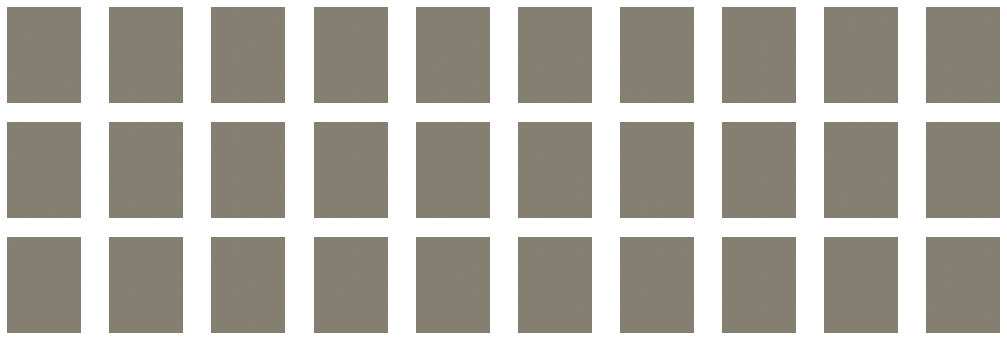

In [25]:
# Output of untrained VAE

plot_image_samples(X_bar[:].detach().cpu())

# Training Loop

In [26]:
# Training Params

opt = torch.optim.Adam(model.parameters())
EPOCHS = 100
THRESHOLD = 1e-4
PATIENCE = 8

history = {'recon-loss': [0], 'kl-loss': [0]}

Epoch [1 / 100] 
    - KL-Loss:  1.720679 
    - Recon-Loss:  752828.447162 
    - Total-Loss:  752830.167841
    - Time-Taken:  23.210705 sec

Epoch [2 / 100] 
    - KL-Loss:  1.643906 
    - Recon-Loss:  747300.070199 
    - Total-Loss:  747301.714105
    - Time-Taken:  24.642151 sec

Epoch [3 / 100] 
    - KL-Loss:  1.486743 
    - Recon-Loss:  746741.839598 
    - Total-Loss:  746743.326342
    - Time-Taken:  25.210709 sec

Epoch [4 / 100] 
    - KL-Loss:  1.306059 
    - Recon-Loss:  746381.097449 
    - Total-Loss:  746382.403508
    - Time-Taken:  26.234078 sec

Epoch [5 / 100] 
    - KL-Loss:  1.365519 
    - Recon-Loss:  746266.844656 
    - Total-Loss:  746268.210174
    - Time-Taken:  25.321104 sec



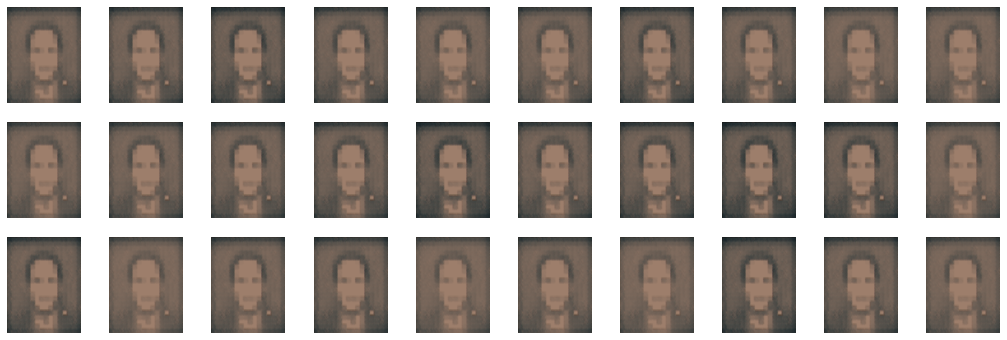


Epoch [6 / 100] 
    - KL-Loss:  1.380570 
    - Recon-Loss:  745887.218146 
    - Total-Loss:  745888.598716
    - Time-Taken:  25.316588 sec

Epoch [7 / 100] 
    - KL-Loss:  1.585576 
    - Recon-Loss:  745866.296045 
    - Total-Loss:  745867.881620
    - Time-Taken:  26.176259 sec

Epoch [8 / 100] 
    - KL-Loss:  2.002721 
    - Recon-Loss:  745699.475619 
    - Total-Loss:  745701.478340
    - Time-Taken:  26.179569 sec

Epoch [9 / 100] 
    - KL-Loss:  2.315324 
    - Recon-Loss:  745690.685839 
    - Total-Loss:  745693.001164
    - Time-Taken:  25.774702 sec

Epoch [10 / 100] 
    - KL-Loss:  2.668883 
    - Recon-Loss:  745472.427008 
    - Total-Loss:  745475.095891
    - Time-Taken:  26.651377 sec



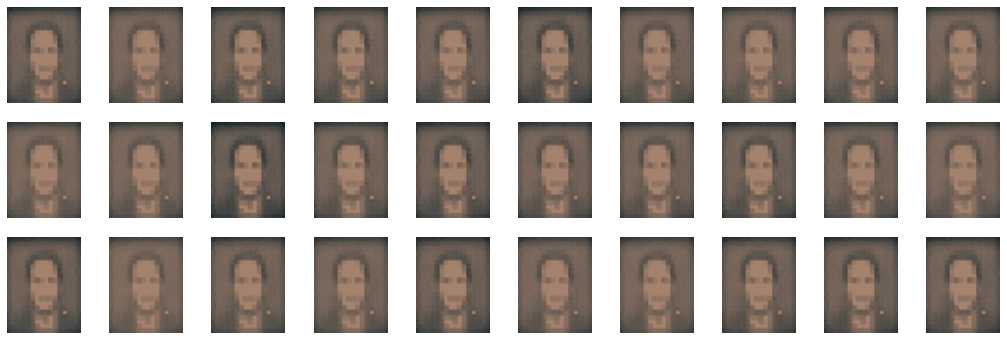


Epoch [11 / 100] 
    - KL-Loss:  3.105198 
    - Recon-Loss:  745436.147947 
    - Total-Loss:  745439.253145
    - Time-Taken:  28.522533 sec

Epoch [12 / 100] 
    - KL-Loss:  3.700223 
    - Recon-Loss:  745418.129076 
    - Total-Loss:  745421.829299
    - Time-Taken:  25.178991 sec

Epoch [13 / 100] 
    - KL-Loss:  4.491235 
    - Recon-Loss:  745517.939463 
    - Total-Loss:  745522.430697
    - Time-Taken:  25.761883 sec

Epoch [14 / 100] 
    - KL-Loss:  5.486409 
    - Recon-Loss:  745540.132246 
    - Total-Loss:  745545.618656
    - Time-Taken:  25.543276 sec

Epoch [15 / 100] 
    - KL-Loss:  6.256788 
    - Recon-Loss:  745287.166516 
    - Total-Loss:  745293.423304
    - Time-Taken:  25.661007 sec



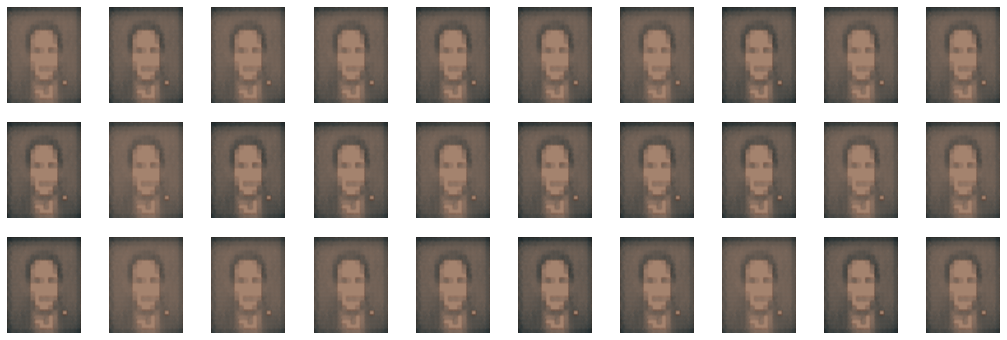


Epoch [16 / 100] 
    - KL-Loss:  7.231305 
    - Recon-Loss:  745331.358620 
    - Total-Loss:  745338.589926
    - Time-Taken:  25.267935 sec

Epoch [17 / 100] 
    - KL-Loss:  8.372688 
    - Recon-Loss:  745441.741546 
    - Total-Loss:  745450.114233
    - Time-Taken:  25.346801 sec

Epoch [18 / 100] 
    - KL-Loss:  9.210026 
    - Recon-Loss:  745259.127793 
    - Total-Loss:  745268.337819
    - Time-Taken:  25.657978 sec

Epoch [19 / 100] 
    - KL-Loss:  9.944132 
    - Recon-Loss:  745322.622434 
    - Total-Loss:  745332.566565
    - Time-Taken:  25.931399 sec

Epoch [20 / 100] 
    - KL-Loss:  11.067672 
    - Recon-Loss:  745287.483469 
    - Total-Loss:  745298.551141
    - Time-Taken:  26.361256 sec



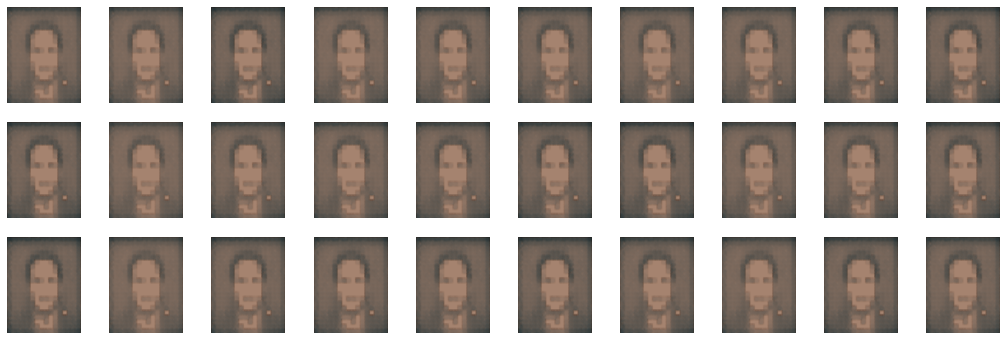


Epoch [21 / 100] 
    - KL-Loss:  12.228296 
    - Recon-Loss:  745263.331824 
    - Total-Loss:  745275.560119
    - Time-Taken:  26.520789 sec

Epoch [22 / 100] 
    - KL-Loss:  13.505792 
    - Recon-Loss:  745502.189236 
    - Total-Loss:  745515.695028
    - Time-Taken:  31.312506 sec

Epoch [23 / 100] 
    - KL-Loss:  14.755893 
    - Recon-Loss:  745217.086957 
    - Total-Loss:  745231.842849
    - Time-Taken:  32.304678 sec

Epoch [24 / 100] 
    - KL-Loss:  15.665454 
    - Recon-Loss:  745315.409194 
    - Total-Loss:  745331.074648
    - Time-Taken:  32.802035 sec

Epoch [25 / 100] 
    - KL-Loss:  16.467833 
    - Recon-Loss:  745199.563255 
    - Total-Loss:  745216.031088
    - Time-Taken:  33.024468 sec



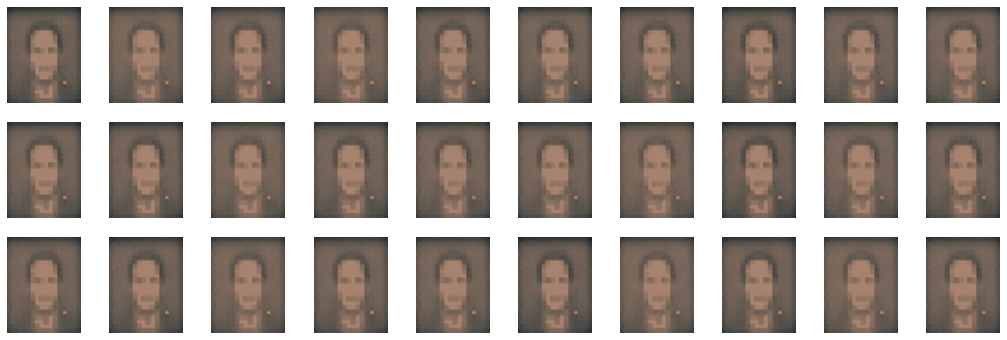


Epoch [26 / 100] 
    - KL-Loss:  17.138517 
    - Recon-Loss:  745234.721014 
    - Total-Loss:  745251.859531
    - Time-Taken:  32.351259 sec

Epoch [27 / 100] 
    - KL-Loss:  18.211188 
    - Recon-Loss:  745171.905420 
    - Total-Loss:  745190.116608
    - Time-Taken:  32.543988 sec

Epoch [28 / 100] 
    - KL-Loss:  19.402137 
    - Recon-Loss:  745159.726147 
    - Total-Loss:  745179.128284
    - Time-Taken:  32.247605 sec

Epoch [29 / 100] 
    - KL-Loss:  20.331220 
    - Recon-Loss:  745166.303970 
    - Total-Loss:  745186.635190
    - Time-Taken:  32.086142 sec

Epoch [30 / 100] 
    - KL-Loss:  20.614791 
    - Recon-Loss:  745108.236715 
    - Total-Loss:  745128.851506
    - Time-Taken:  32.565555 sec



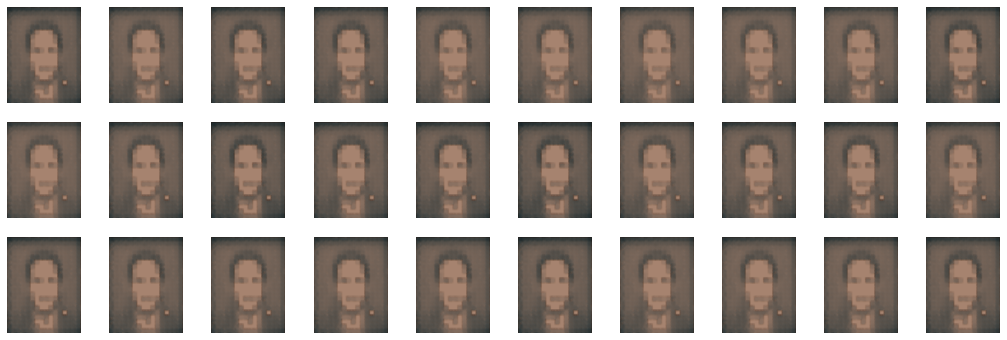


Epoch [31 / 100] 
    - KL-Loss:  21.192247 
    - Recon-Loss:  745045.727959 
    - Total-Loss:  745066.920206
    - Time-Taken:  32.329076 sec

Epoch [32 / 100] 
    - KL-Loss:  21.895919 
    - Recon-Loss:  745143.729695 
    - Total-Loss:  745165.625614
    - Time-Taken:  32.045006 sec

Epoch [33 / 100] 
    - KL-Loss:  22.476636 
    - Recon-Loss:  745169.498943 
    - Total-Loss:  745191.975579
    - Time-Taken:  33.048476 sec

Epoch [34 / 100] 
    - KL-Loss:  22.739842 
    - Recon-Loss:  745124.442482 
    - Total-Loss:  745147.182324
    - Time-Taken:  31.979806 sec

Epoch [35 / 100] 
    - KL-Loss:  23.292412 
    - Recon-Loss:  745127.021739 
    - Total-Loss:  745150.314151
    - Time-Taken:  32.797422 sec



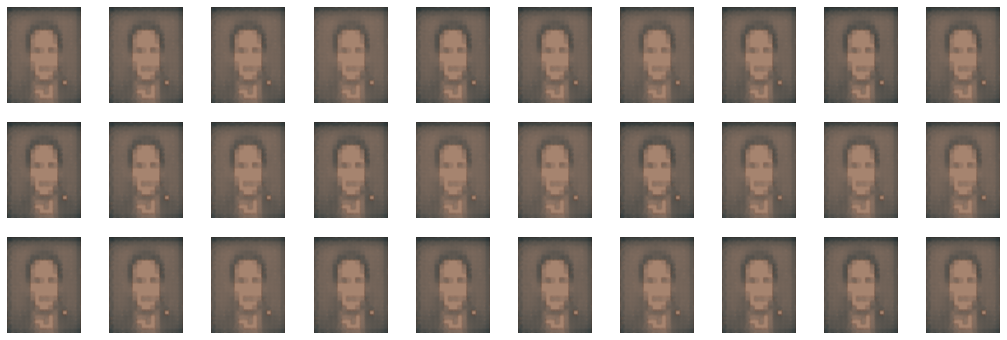

KeyboardInterrupt: 

In [27]:
# Custom Training Loop

model.train()

round = 0
loss_inc_count = 0

for epoch in range(EPOCHS):
    count = 0
    tick = time()
    l1, l2 = 0, 0

    for idx, X in enumerate(data):
        count += 1

        # Copy data to Device
        X = X[0].to(device)

        # Forward Pass
        reconstructed_x, mu, log_var = model.forward(X)
        
        # Loss Calculation
        rec_loss = model.reconstr_loss
        kl_loss = model.kl_loss
        loss = rec_loss + kl_loss
        
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        
        # Apply Jacobians to Weights
        opt.step()

        l1 += rec_loss.item()
        l2 += kl_loss.item()
        
    # Log Training
    history["recon-loss"].append(l1/count)
    history["kl-loss"].append(l2/count)
    
    # Training Moniotring
    tock = time()
    round += 1
    print(f"""Epoch [{round} / {EPOCHS}] 
    - KL-Loss: {history["kl-loss"][-1]: 0.6f} 
    - Recon-Loss: {history["recon-loss"][-1]: 0.6f} 
    - Total-Loss: {(history["kl-loss"][-1] + history["recon-loss"][-1]): 0.6f}
    - Time-Taken: {(tock-tick): 0.6f} sec""", end="\n\n")
    
    # Plot Randomly Sampled Latent Embeddings
    if round%5 == 0:
        plot_image_samples(model.decoder(torch.randn((32, LATENT_DIMS)).to(device)).detach().cpu())
        print()

    # Early Stopping
    if (history["kl-loss"][-1]  - history["kl-loss"][-2] + history["recon-loss"][-1] - history["recon-loss"][-2]) < 0:
        loss_inc_count += 0
    if ((abs(history["kl-loss"][-1]  - history["kl-loss"][-2]) + abs(history["recon-loss"][-1] - history["recon-loss"][-2])) <= THRESHOLD) or (loss_inc_count >= PATIENCE):
        break

In [ ]:
# Training Visualization

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history["recon-loss"])
plt.title("Recostruction Loss")

plt.subplot(1, 3, 2)
plt.plot(history["kl-loss"])
plt.title("KL Loss")

plt.subplot(1, 3, 3)
plt.plot(history["recon-loss"]+history["kl-loss"])
plt.title("Total Loss")

plt.show()

In [ ]:
# Visualizing Latent Space

N = 1000 #No of Parameters
N_sample = 3 #No. of Samples per parameter

# Sampling Images
temp = [next(iter(data)) for _ in range(N//32 + 1)]
X = torch.vstack([x[0] for x in temp])
Y = torch.hstack([x[1] for x in temp])

# Forward Pass through Encoder
mu_, _log_var = model.encoder(X.to(device))

# Sampling from Normal Disitrbution using predicted Parameters
embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()
embedding_class = torch.hstack([Y for _ in range(N_sample)]).detach().cpu().numpy()

# Dimensionality Reduction
low_dim_embeddings = KernelPCA(n_components=2, kernel="poly").fit_transform(embeddings)

# Plotting Principle Components
plt.figure(figsize=(16,8))
plt.scatter(x = low_dim_embeddings[:,0], 
            y = low_dim_embeddings[:, 1], 
            alpha=0.6)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

# Checkpointing

In [ ]:
# Saving Model

# torch.save(model.state_dict(), "./brain-tumor-vae.pt")